### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import pickle

### Load the data file

In [2]:
df = pd.read_csv('games.csv')
df.head(2)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN


### Filter out data, taking only the useful attributes from the dataset.

In [3]:
filtered_df = df[['Name', 'Platform', 'Genre', 'Developer', 'Critic_Score', 'User_Score', 'Rating']]
filtered_df.head(2)

,Name,Platform,Genre,Developer,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,Sports,Nintendo,76.0,8,E
1,Super Mario Bros.,NES,Platform,NaN,NaN,NaN,NaN


In [4]:
filtered_df.shape

(16719, 7)

### Handling missing data points

In [5]:
filtered_df.isnull().sum()

Name               2
Platform           0
Genre              2
Developer       6623
Critic_Score    8582
User_Score      6704
Rating          6769
dtype: int64

In [6]:
filtered_df.dropna(inplace=True)

/var/folders/05/w7q30nw51kqf2q34f0fgz46h0000gn/T/ipykernel_5428/724713040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(inplace=True)


In [7]:
filtered_df.shape

(8025, 7)

In [8]:
filtered_df.isnull().sum()

Name            0
Platform        0
Genre           0
Developer       0
Critic_Score    0
User_Score      0
Rating          0
dtype: int64

### Filter out duplicate entries from the dataset

In [9]:
filtered_df.duplicated().sum()

4

In [10]:
filtered_df = filtered_df.drop_duplicates()
filtered_df.duplicated().sum()

0

In [11]:
filtered_df.shape

(8021, 7)

### Remove duplicate entries for game names

In [12]:
filtered_df.drop_duplicates(subset='Name', keep='first', inplace=True)
filtered_df.shape

(5012, 7)

### Use collections Counter to check the sum of each platform column element

In [13]:
platform_counter = Counter(filtered_df['Platform'])
platform_counter

Counter({'PS2': 1174,
         'DS': 538,
         'PS3': 457,
         'X360': 453,
         'Wii': 412,
         'GBA': 322,
         'PSP': 295,
         'PC': 290,
         'XB': 243,
         'PS4': 204,
         'PS': 178,
         'GC': 140,
         '3DS': 134,
         'PSV': 80,
         'WiiU': 52,
         'XOne': 28,
         'DC': 12})

### Removes columns with counts less than 350

In [14]:
platform_less_than_350 = ['2600', '3DO', 'DC', 'GB', 'GEN', 'GG', 'N64','NES', 'NG','PCFX', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'WiiU', 'XOne']
filtered_df = filtered_df[~filtered_df['Platform'].isin(platform_less_than_350)]

### Check the sum of each unique Genre

In [15]:
genre_counter = Counter(filtered_df['Genre'])
genre_counter

Counter({'Action': 951,
         'Role-Playing': 598,
         'Sports': 596,
         'Shooter': 536,
         'Racing': 414,
         'Misc': 336,
         'Platform': 305,
         'Simulation': 269,
         'Fighting': 265,
         'Strategy': 235,
         'Adventure': 229,
         'Puzzle': 186})

### Remove row with misc genre

In [16]:
filtered_df = filtered_df[filtered_df['Genre'] != 'Misc']

### Use collections Counter to check the sum of each rating column element

In [17]:
rating_counter = Counter(filtered_df['Rating'])
rating_counter

Counter({'E': 1616, 'T': 1609, 'M': 815, 'E10+': 542, 'RP': 2})

### Remove row with RP Rating

In [18]:
filtered_df = filtered_df[filtered_df['Rating'] != 'RP']

In [19]:
filtered_df.shape

(4582, 7)

### Visualising data distribution

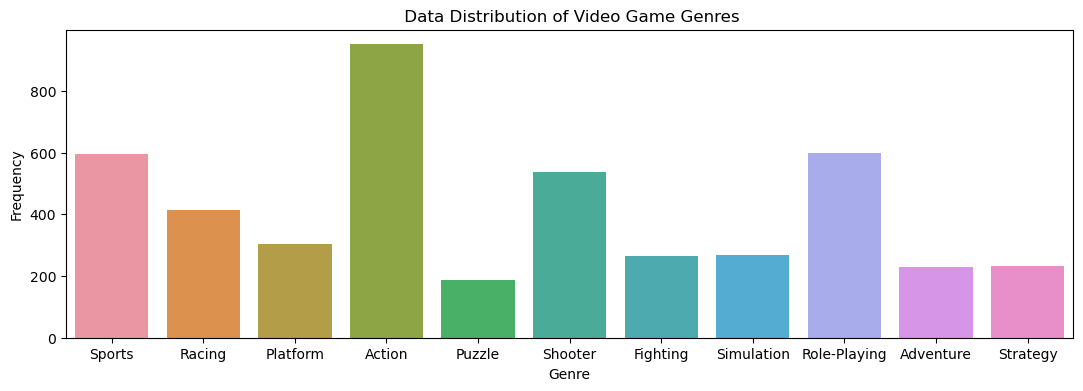

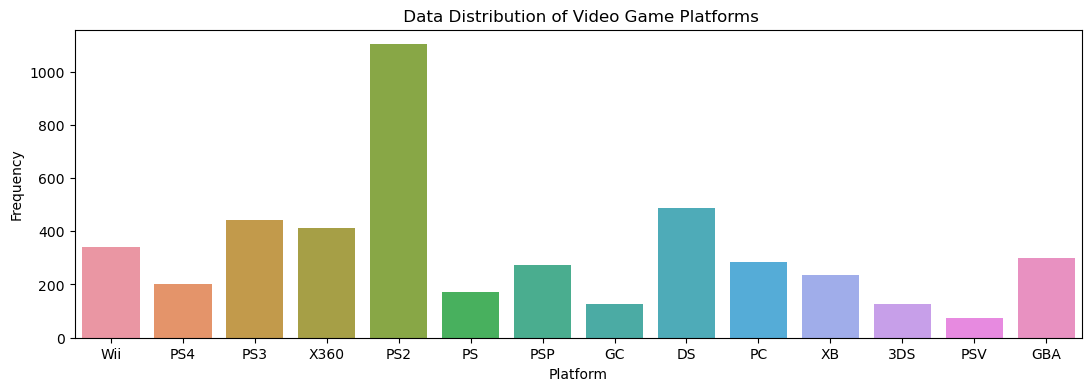

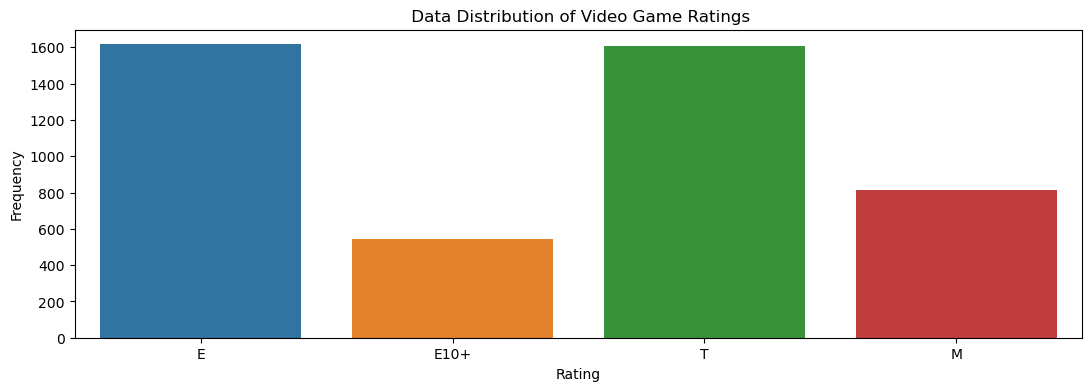

In [43]:
features = filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (13,4))
    sns.countplot(data=filtered_df, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
plt.show()

### Replace 'tbd' value to NaN

In [21]:
filtered_df['User_Score'] = np.where(filtered_df['User_Score'] == 'tbd', np.nan,filtered_df['User_Score']).astype(float)

### Group the records by Genre, then aggregate them calculating the average of both Critic Score and User Score

In [22]:

video_game_grpby_genre = filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False)
video_game_score_mean = video_game_grpby_genre.agg(Ave_Critic_Score = ('Critic_Score', 'mean'), Ave_User_Score = ('User_Score', 'mean'))

### Merge the average scores with the main dataframe

In [23]:
filtered_df = filtered_df.merge(video_game_score_mean, on='Genre')
filtered_df

,Name,Platform,Genre,Developer,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,Nintendo,76.0,8.0,E,69.630872,7.244581
1,Wii Sports Resort,Wii,Sports,Nintendo,80.0,8.0,E,69.630872,7.244581
2,Wii Fit,Wii,Sports,Nintendo,80.0,7.7,E,69.630872,7.244581
3,Wii Fit Plus,Wii,Sports,Nintendo,80.0,7.4,E,69.630872,7.244581
4,FIFA 16,PS4,Sports,EA Sports,82.0,4.3,E,69.630872,7.244581
...,...,...,...,...,...,...,...,...,...
4577,Homeworld Remastered Collection,PC,Strategy,Gearbox Software,86.0,8.2,E10+,72.403433,7.430909
4578,BattleForge,PC,Strategy,EA Phenomic,75.0,7.0,T,72.403433,7.430909
4579,The Eye of Judgment: Legends,PSP,Strategy,SCEI,69.0,7.9,E10+,72.403433,7.430909
4580,Hospital Tycoon,PC,Strategy,Big Red Software,51.0,3.8,E10+,72.403433,7.430909


#### The code handles missing values in the Critic_Score and User_Score columns by replacing them with average scores (Ave_Critic_Score and Ave_User_Score respectively).It uses the np.where function to perform this replacement conditionally.The resulting DataFrame has new columns (Critic_Score_Imputed and User_Score_Imputed) with imputed values.

In [24]:
filtered_df['Critic_Score_Imputed'] = np.where(filtered_df['Critic_Score'].isna(), 
                                               filtered_df['Ave_Critic_Score'], 
                                               filtered_df['Critic_Score'])

filtered_df['User_Score_Imputed'] = np.where(filtered_df['User_Score'].isna(), 
                                             filtered_df['Ave_User_Score'], 
                                             filtered_df['User_Score'])
filtered_df

,Name,Platform,Genre,Developer,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Imputed,User_Score_Imputed
0,Wii Sports,Wii,Sports,Nintendo,76.0,8.0,E,69.630872,7.244581,76.0,8.0
1,Wii Sports Resort,Wii,Sports,Nintendo,80.0,8.0,E,69.630872,7.244581,80.0,8.0
2,Wii Fit,Wii,Sports,Nintendo,80.0,7.7,E,69.630872,7.244581,80.0,7.7
3,Wii Fit Plus,Wii,Sports,Nintendo,80.0,7.4,E,69.630872,7.244581,80.0,7.4
4,FIFA 16,PS4,Sports,EA Sports,82.0,4.3,E,69.630872,7.244581,82.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
4577,Homeworld Remastered Collection,PC,Strategy,Gearbox Software,86.0,8.2,E10+,72.403433,7.430909,86.0,8.2
4578,BattleForge,PC,Strategy,EA Phenomic,75.0,7.0,T,72.403433,7.430909,75.0,7.0
4579,The Eye of Judgment: Legends,PSP,Strategy,SCEI,69.0,7.9,E10+,72.403433,7.430909,69.0,7.9
4580,Hospital Tycoon,PC,Strategy,Big Red Software,51.0,3.8,E10+,72.403433,7.430909,51.0,3.8


In [25]:
final_df = filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
final_df = final_df.reset_index(drop=True)

final_df = final_df.rename(columns={'Critic_Score_Imputed':'Critic_Score', 'User_Score_Imputed':'User_Score'})
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4582 entries, 0 to 4581
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4582 non-null   object 
 1   Platform      4582 non-null   object 
 2   Genre         4582 non-null   object 
 3   Developer     4582 non-null   object 
 4   Rating        4582 non-null   object 
 5   Critic_Score  4582 non-null   float64
 6   User_Score    4582 non-null   float64
dtypes: float64(2), object(5)
memory usage: 250.7+ KB


In [26]:
final_df

,Name,Platform,Genre,Developer,Rating,Critic_Score,User_Score
0,Wii Sports,Wii,Sports,Nintendo,E,76.0,8.0
1,Wii Sports Resort,Wii,Sports,Nintendo,E,80.0,8.0
2,Wii Fit,Wii,Sports,Nintendo,E,80.0,7.7
3,Wii Fit Plus,Wii,Sports,Nintendo,E,80.0,7.4
4,FIFA 16,PS4,Sports,EA Sports,E,82.0,4.3
...,...,...,...,...,...,...,...
4577,Homeworld Remastered Collection,PC,Strategy,Gearbox Software,E10+,86.0,8.2
4578,BattleForge,PC,Strategy,EA Phenomic,T,75.0,7.0
4579,The Eye of Judgment: Legends,PSP,Strategy,SCEI,E10+,69.0,7.9
4580,Hospital Tycoon,PC,Strategy,Big Red Software,E10+,51.0,3.8


### Merging all the important attributes in a new tags column to pass to counter vectorizer

In [27]:
final_df['tags'] =final_df['Platform'].astype(str) + ',' + \
                    final_df['Genre'].astype(str) + ',' + \
                    final_df['Developer'].astype(str) + ',' + \
                    final_df['Rating'].astype(str) + ',' + \
                    final_df['Critic_Score'].astype(str) + ',' + \
                    final_df['User_Score'].astype(str)


In [28]:
final_df.iloc[0]['tags']

'Wii,Sports,Nintendo,E,76.0,8.0'

### Dataset attributes used for NLP

In [29]:
games = final_df[['Name','tags']]
games

,Name,tags
0,Wii Sports,"Wii,Sports,Nintendo,E,76.0,8.0"
1,Wii Sports Resort,"Wii,Sports,Nintendo,E,80.0,8.0"
2,Wii Fit,"Wii,Sports,Nintendo,E,80.0,7.7"
3,Wii Fit Plus,"Wii,Sports,Nintendo,E,80.0,7.4"
4,FIFA 16,"PS4,Sports,EA Sports,E,82.0,4.3"
...,...,...
4577,Homeworld Remastered Collection,"PC,Strategy,Gearbox Software,E10+,86.0,8.2"
4578,BattleForge,"PC,Strategy,EA Phenomic,T,75.0,7.0"
4579,The Eye of Judgment: Legends,"PSP,Strategy,SCEI,E10+,69.0,7.9"
4580,Hospital Tycoon,"PC,Strategy,Big Red Software,E10+,51.0,3.8"


### Convert the tags to paragraph form for counter vectorizer

In [30]:
games['tags'] = games['tags'].apply(lambda x: ' '.join(x.split(',')))
games

/var/folders/05/w7q30nw51kqf2q34f0fgz46h0000gn/T/ipykernel_5428/3093056830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['tags'] = games['tags'].apply(lambda x: ' '.join(x.split(',')))


,Name,tags
0,Wii Sports,Wii Sports Nintendo E 76.0 8.0
1,Wii Sports Resort,Wii Sports Nintendo E 80.0 8.0
2,Wii Fit,Wii Sports Nintendo E 80.0 7.7
3,Wii Fit Plus,Wii Sports Nintendo E 80.0 7.4
4,FIFA 16,PS4 Sports EA Sports E 82.0 4.3
...,...,...
4577,Homeworld Remastered Collection,PC Strategy Gearbox Software E10+ 86.0 8.2
4578,BattleForge,PC Strategy EA Phenomic T 75.0 7.0
4579,The Eye of Judgment: Legends,PSP Strategy SCEI E10+ 69.0 7.9
4580,Hospital Tycoon,PC Strategy Big Red Software E10+ 51.0 3.8


### Convert all the tags to lower case to avoid duplicate words

In [31]:
games['tags'] = games['tags'].apply(lambda x:x.lower())
games

/var/folders/05/w7q30nw51kqf2q34f0fgz46h0000gn/T/ipykernel_5428/1762010933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['tags'] = games['tags'].apply(lambda x:x.lower())


,Name,tags
0,Wii Sports,wii sports nintendo e 76.0 8.0
1,Wii Sports Resort,wii sports nintendo e 80.0 8.0
2,Wii Fit,wii sports nintendo e 80.0 7.7
3,Wii Fit Plus,wii sports nintendo e 80.0 7.4
4,FIFA 16,ps4 sports ea sports e 82.0 4.3
...,...,...
4577,Homeworld Remastered Collection,pc strategy gearbox software e10+ 86.0 8.2
4578,BattleForge,pc strategy ea phenomic t 75.0 7.0
4579,The Eye of Judgment: Legends,psp strategy scei e10+ 69.0 7.9
4580,Hospital Tycoon,pc strategy big red software e10+ 51.0 3.8


### Extract root words from a given word to avoid duplicate words

In [32]:
ps = PorterStemmer()

def stems(text):
    l=[]
    for i in text.split():
        l.append(ps.stem(i))
    return " ".join(l)

games['tags'] = games['tags'].apply(stems)

/var/folders/05/w7q30nw51kqf2q34f0fgz46h0000gn/T/ipykernel_5428/3112470953.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['tags'] = games['tags'].apply(stems)


In [33]:
games['tags']

0                   wii sport nintendo e 76.0 8.0
1                   wii sport nintendo e 80.0 8.0
2                   wii sport nintendo e 80.0 7.7
3                   wii sport nintendo e 80.0 7.4
4                   ps4 sport ea sport e 82.0 4.3
                          ...                    
4577    pc strategi gearbox softwar e10+ 86.0 8.2
4578             pc strategi ea phenom t 75.0 7.0
4579              psp strategi scei e10+ 69.0 7.9
4580    pc strategi big red softwar e10+ 51.0 3.8
4581             pc strategi simbin e10+ 60.0 7.2
Name: tags, Length: 4582, dtype: object

### Counter Vectorizer: Forms vectors for all data entries based on attributes

In [34]:
cv = CountVectorizer(max_features=6000, stop_words= 'english')
vector = cv.fit_transform(games['tags']).toarray()
vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
vector.shape

(4582, 1364)

### Cosine Similarity: Takes angle between two vectors to decide which vectors are closest to each other

In [36]:
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.75      , 0.75      , ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.3380617 ,
        0.4       ],
       [0.        , 0.        , 0.        , ..., 0.3380617 , 1.        ,
        0.50709255],
       [0.        , 0.        , 0.        , ..., 0.4       , 0.50709255,
        1.        ]])

In [37]:
similarity.shape

(4582, 4582)

### Function to test the recommender system

In [38]:
def recommend(game):
    index = games[games['Name'] == game].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse = True , key = lambda x : x[1]) # Sort on the basis of the key (data) and not the indices
    for i in distances[1:6]:
        print(games.iloc[i[0]].Name)

In [39]:
recommend('Grand Theft Auto V')

Grand Theft Auto: San Andreas
Grand Theft Auto: Vice City
Grand Theft Auto IV
Manhunt
Red Dead Redemption


### Store Data in Pickle files

In [40]:
pickle.dump(games, open('artifacts/game_list.pkl','wb'))
pickle.dump(similarity, open('artifacts/similarity.pkl','wb'))